# UCLA Master in Quantitative Economics 
## Replication File for <i>Re-estimating the Effect of Skill Specificity on Immigration Attitudes: A Double/Debiased Machine Learning Approach<i>
### Author: Nathan Kim 
### Faculty Advisor: Denis Chetverikov

In [1]:
# Standard modules 
import random
import numpy as np 
import pandas as pd 
from scipy.stats import norm 
import matplotlib.pyplot as plt 

In [2]:
# Utilities 
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures 

In [3]:
# Linear, tree-based, and ensemble models 
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor 
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [4]:
# dmlc XGBoost 
import xgboost as xgb

In [5]:
# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras import regularizers
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

# Data import & cleaning 

In [6]:
# Import data
df = pd.read_stata('gsp_data_final.dta')

In [7]:
# Treatment group should be unemployed sometime during 2003 to 2005
print(df.loc[df['treated'] == 1]['unemployed2'].unique())
print(df.loc[df['treated'] == 1]['syear'].unique())

[1.]
[2004 2003 2005]


In [8]:
# Subsetting data 
df = df[['syear', 'pid', 'concern_rec', 'treated', 'unemployed2', 'income', 'age', 'educyears', 'skillsp', 'our', 
         'tenure2', 'transition', 'percentimmigr', 'manualwork', 'gender', 'temporary', 'dv', 'churchatt', 'pgsbil']]

In [9]:
# Sort by surveyee ID and survey year 
df = df.sort_values(by=['pid', 'syear'])

In [10]:
df.head()

,syear,pid,concern_rec,treated,unemployed2,income,age,educyears,skillsp,our,tenure2,transition,percentimmigr,manualwork,gender,temporary,dv,churchatt,pgsbil
0,1999,201,2.0,0.0,0.0,NaN,73.0,11.0,NaN,NaN,10.770837,NaN,6.917376,0.0,2.0,0.0,0.0,2.0,1
1,2000,201,2.0,0.0,0.0,NaN,74.0,10.5,NaN,NaN,3.410256,NaN,82.347237,0.0,2.0,0.0,0.0,2.0,1
2,2001,201,NaN,0.0,0.0,NaN,75.0,10.5,NaN,NaN,11.610270,NaN,81.313133,0.0,2.0,0.0,NaN,2.0,1
3,2002,201,1.0,0.0,0.0,NaN,76.0,10.5,NaN,NaN,7.950000,NaN,83.075089,0.0,2.0,0.0,0.0,2.0,1
4,2003,201,2.0,0.0,0.0,NaN,77.0,10.5,NaN,NaN,12.263576,NaN,80.788483,0.0,2.0,0.0,0.0,2.0,1


In [11]:
# Number of observations each year 
df.dropna().groupby(by='syear').size()

syear
2000    11849
2001     1786
2002    11606
2003     1362
2004    10442
2005     1161
2006     1772
2007     9661
2008     1699
2009     9692
2010     1458
2011     9674
dtype: int64

In [12]:
# Dataframe containing only the years 2003, 2004, and 2005 (i.e. treatment period)
time_frame = df.loc[(df['syear'] == 2003) | (df['syear'] == 2004) | (df['syear'] == 2005)]

In [13]:
# Verifying the above code
print(time_frame['syear'].unique())

[2003 2004 2005]


In [14]:
# Sort by surveyee ID and survey year 
time_frame = time_frame.sort_values(by=['pid', 'syear'])

In [15]:
time_frame.head()

,syear,pid,concern_rec,treated,unemployed2,income,age,educyears,skillsp,our,tenure2,transition,percentimmigr,manualwork,gender,temporary,dv,churchatt,pgsbil
4,2003,201,2.0,0.0,0.0,NaN,77.0,10.5,NaN,NaN,12.263576,NaN,80.788483,0.0,2.0,0.0,0.0,2.0,1
5,2004,201,3.0,0.0,0.0,NaN,78.0,10.5,NaN,NaN,9.666667,NaN,84.533333,0.0,2.0,0.0,1.0,2.0,1
6,2005,201,1.0,0.0,0.0,NaN,79.0,10.5,NaN,NaN,12.523881,NaN,80.142349,0.0,2.0,0.0,0.0,2.0,1
14,2003,203,2.0,0.0,0.0,4.0,43.0,18.0,NaN,NaN,12.263576,NaN,80.788483,0.0,1.0,0.0,0.0,1.0,4
15,2004,203,2.0,1.0,1.0,NaN,44.0,18.0,NaN,NaN,9.666667,NaN,84.533333,0.0,1.0,0.0,0.0,2.0,4


In [16]:
# Find IDs of surveyees that were unemployed (treated) during 2003-2005 
treated_id = list(time_frame.loc[time_frame['unemployed2'] == 1]['pid'].unique())

In [17]:
# Verifying the above code 
(treated_id == list(df.loc[df['treated'] == 1]['pid'].unique()))

True

In [18]:
# Find IDs of surveyees that were employed all throughout 2003-2005 (control)
control_2003 = list(time_frame.loc[(time_frame['unemployed2'] == 0) & (time_frame['syear'] == 2003)]['pid'].unique())
control_2004 = list(time_frame.loc[(time_frame['unemployed2'] == 0) & (time_frame['syear'] == 2004)]['pid'].unique())
control_2005 = list(time_frame.loc[(time_frame['unemployed2'] == 0) & (time_frame['syear'] == 2005)]['pid'].unique())

In [19]:
control_id = list(set(control_2003) & set(control_2004) & set(control_2005))

In [20]:
# Treated and control groups are mutually exclusive 
bool(set(treated_id) & set(control_id))

False

In [21]:
# All IDs including both treated and control groups
relevant_id = treated_id + control_id

In [22]:
# 1 == male, 2 == female 
# Replace 2 with 0 to create 'male' dummy variable 
df['gender'] = df['gender'].replace(2, 0)

In [23]:
# 1 == yes, 2 == no
# Replace 2 with 0 to create 'church attendance' dummy variable 
df['churchatt'] = df['churchatt'].replace(2, 0)

In [24]:
# Type of schooling 
df['pgsbil'] = df['pgsbil'].replace(-1, np.nan)

In [25]:
stype_dummies = pd.get_dummies(df['pgsbil'])

In [26]:
stype_dummies.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [27]:
stype_dummies = stype_dummies.rename(columns = {1.0 : 'stype1', 2.0 : 'stype2', 3.0 : 'stype3', 4.0 : 'stype4', 
                                      5.0 : 'stype5', 6.0 : 'stype6', 7.0 : 'stype7' })

In [28]:
df = pd.concat([df, stype_dummies], axis=1)

In [29]:
df = df.drop('pgsbil', axis=1)

In [30]:
# Slice dataframe with years 2002 and 2011

# Before treatment = 2002 
# After treatment = 2011

df_2002 = df.loc[df['syear'] == 2002].dropna()
df_2002 = df_2002.loc[df_2002['pid'].isin(relevant_id)]

df_2011 = df.loc[df['syear'] == 2011].dropna()
df_2011 = df_2011.loc[df_2011['pid'].isin(relevant_id)]

In [31]:
# Each year does not have the same number of surveyees/same surveyee IDs  
syear_id = list(df_2002.loc[df_2002['pid'].isin(df_2011['pid'])]['pid'])

In [32]:
df = df.loc[(df['pid'].isin(syear_id)) & ((df['syear'] == 2002) | (df['syear'] == 2011))].reset_index(drop=True)

In [33]:
df['treated'] = 0 
df.loc[df['pid'].isin(treated_id), 'treated'] = 1

In [34]:
df.head()

,syear,pid,concern_rec,treated,unemployed2,income,age,educyears,skillsp,our,...,temporary,dv,churchatt,stype1,stype2,stype3,stype4,stype5,stype6,stype7
0,2002,901,2.0,0,0.0,2.0,51.0,10.5,0.617639,9.205261,...,0.0,0.0,1.0,1,0,0,0,0,0,0
1,2011,901,2.0,0,0.0,3.0,60.0,10.5,0.490324,8.017141,...,0.0,0.0,1.0,1,0,0,0,0,0,0
2,2002,1501,1.0,0,0.0,3.0,44.0,18.0,0.719778,3.658580,...,0.0,0.0,1.0,0,0,0,1,0,0,0
3,2011,1501,1.0,0,0.0,5.0,53.0,18.0,0.708843,2.422332,...,0.0,0.0,1.0,0,0,0,1,0,0,0
4,2002,2301,2.0,0,0.0,5.0,56.0,18.0,0.719778,3.658580,...,0.0,0.0,1.0,0,0,0,1,0,0,0


In [35]:
df.tail()

,syear,pid,concern_rec,treated,unemployed2,income,age,educyears,skillsp,our,...,temporary,dv,churchatt,stype1,stype2,stype3,stype4,stype5,stype6,stype7
8203,2011,8249801,1.0,0,0.0,4.0,55.0,18.0,0.708843,2.422332,...,0.0,0.0,1.0,0,0,0,1,0,0,0
8204,2002,8249802,2.0,0,0.0,4.0,43.0,17.0,0.719778,3.658580,...,0.0,0.0,1.0,0,0,1,0,0,0,0
8205,2011,8249802,1.0,0,0.0,5.0,52.0,18.0,0.708843,2.422332,...,0.0,0.0,1.0,0,0,0,1,0,0,0
8206,2002,8249803,1.0,0,0.0,1.0,21.0,13.0,3.047472,11.855548,...,1.0,0.0,1.0,0,0,0,1,0,0,0
8207,2011,8249803,1.0,0,0.0,2.0,30.0,18.0,0.708843,2.422332,...,1.0,0.0,1.0,0,0,0,1,0,0,0


In [36]:
df.shape

(8208, 25)

# DMLDiD Estimator

In [37]:
def DMLDiD(Y_1, Y_0, D, X, g_ML, g_params, mu_ML, mu_params):
    
    # Function works for sklearn and dmlc's XGBoost (uses sklearn wrapper)
    
    Y_1 = Y_1.reshape(-1, 1) # Reshape arrays to 2D 
    Y_0 = Y_0.reshape(-1, 1) # ""
    D = D.reshape(-1, 1)     # ""
    
    df = np.concatenate((Y_1, Y_0, D, X), axis=1) # Combine everything into one 2D array 
    
    np.random.seed(123) # Set seed for replicability
    np.random.shuffle(df) # Shuffle data 
    
    K = 2 # Number of folds for cross-fitting 
    N = Y_1.shape[0] # Number of individuals (observations)
    n = round(df.shape[0] / K) # Number of approx observations for each fold
    
    df_I_k = [df[:n, :], df[n:, :]] # List of partions/folds
    
    att_I_k, var_I_k = [], [] # Empty lists to hold results for each fold 
    
    for df_k in df_I_k: # For each fold calculate DMLDiD 
        D, X = df_k[:, 2], df_k[:, 3:]
        
        p_hat = np.mean(D)
        
        prop_score = GridSearchCV(estimator=g_ML, param_grid=g_params, scoring='neg_log_loss', cv=2)
        prop_score.fit(X, D)
        
        g_hat = prop_score.predict_proba(X)[:, 1]
        
        df_mu = df_k[np.where(df_k[:, 2] == 0)]
        
        Y_1_mu, Y_0_mu, X_mu = df_mu[:, 0], df_mu[:, 1], df_mu[:, 3:]
      
        cond_mean = GridSearchCV(estimator=mu_ML, param_grid=mu_params, scoring='neg_mean_squared_error', cv=2)
        cond_mean.fit(X_mu, Y_1_mu - Y_0_mu) 
        
        mu_hat = cond_mean.predict(X)
        
        Y_1, Y_0 = df_k[:, 0], df_k[:, 1]
    
        t0 = ((Y_1 - Y_0) / p_hat) * ((D - g_hat) / (1 - g_hat))
        
        c1 = ((D - g_hat) / (p_hat * (1 - g_hat))) * mu_hat
        
        att_k = np.mean(t0 - c1)
        
        att_I_k.append(att_k)
    
    theta = np.mean(att_I_k)
    
    for df_k in df_I_k: # For each fold calculate variance
        D, X = df_k[:, 2], df_k[:, 3:]
        
        p_hat = np.mean(D)
        
        prop_score = GridSearchCV(estimator=g_ML, param_grid=g_params, scoring='neg_log_loss', cv=2)
        prop_score.fit(X, D)
        
        g_hat = prop_score.predict_proba(X)[:, 1]
        
        df_mu = df_k[np.where(df_k[:, 2] == 0)]
        
        Y_1_mu, Y_0_mu, X_mu = df_mu[:, 0], df_mu[:, 1], df_mu[:, 3:]
        
        cond_mean = GridSearchCV(estimator=mu_ML, param_grid=mu_params, scoring='neg_mean_squared_error', cv=2)
        cond_mean.fit(X_mu, Y_1_mu - Y_0_mu)
        
        mu_hat = cond_mean.predict(X)
        
        Y_1, Y_0 = df_k[:, 0], df_k[:, 1]
    
        psi = (((Y_1 - Y_0) / p_hat) * ((D - g_hat) / (1 - g_hat))) - theta
        psi = psi - (((D - g_hat) / (p_hat * (1 - g_hat))) * mu_hat)

        G = (-1 * theta) / p_hat
    
        var_k = np.mean((psi + (G * (D - p_hat))) ** 2)
        
        var_I_k.append(var_k)
        
    sigma = np.mean(var_I_k)
    
    return theta, np.sqrt(sigma / N)

In [38]:
def build_model(mspec, optimizer, lr, reg, n_inputs, clf):

    model = keras.Sequential() # Feedforward neural network 
    
    model.add(layers.Dense(units=mspec[0], activation='relu', kernel_regularizer=regularizers.L1(reg), 
                           input_shape=(n_inputs,))) # First hidden layer 
    
    opt = tf.keras.optimizers.SGD(learning_rate=lr) # Use stochastic GD by default 
    
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=lr) # Use Adam if specified 
    
    for m in mspec[1:]:
        model.add(layers.Dense(units=m, activation='relu', kernel_regularizer=regularizers.L1(reg))) 
        
    if clf:
        model.add(layers.Dense(units=1, activation='sigmoid')) # Sigmoid output for classification 
        model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy'])
    else: 
        model.add(layers.Dense(units=1))
        model.compile(optimizer=opt, loss=MeanSquaredError(), metrics=['mse']) 
        
    return model 

In [39]:
def grid_search(mspecs, optimizers, lrates, regs, X, y, n_inputs, clf): 
    
    np.random.seed(123)
    tf.random.set_seed(123)
    
    hidden_layers, opt_names, lrate_values, reg_values, loss_values = [], [], [], [], []
    
    kf = KFold(n_splits=2, random_state=0, shuffle=True)
    
    if clf:
        kf = StratifiedKFold(n_splits=2, random_state=0, shuffle=True) 
    
    for o in optimizers:
        for m in mspecs:
            for lr in lrates: 
                for re in regs:

                    model = build_model(m, o, lr, re, n_inputs, clf) 

                    fold_loss = [] 

                    for train_idx, test_idx in kf.split(X, y):
                        model.fit(X[train_idx], y[train_idx], batch_size=32, epochs=20, verbose=0)

                        loss, metric = model.evaluate(X[test_idx], y[test_idx], verbose=0)
                        fold_loss.append(loss)

                    mean_loss = np.mean(fold_loss)

                    hidden_layers.append(m)
                    opt_names.append(o)
                    lrate_values.append(lr)
                    reg_values.append(re)
                    loss_values.append(mean_loss)
        
        
    min_idx = np.argmin(loss_values)
    
    return hidden_layers[min_idx], opt_names[min_idx], lrate_values[min_idx], reg_values[min_idx]

In [40]:
def DMLDiD_TF(Y_1, Y_0, D, X, n_inputs, g_params, mu_params):
    
    # Same function as DMLDiD() but for TensorFlow 
    
    Y_1 = Y_1.reshape(-1, 1) # Reshape arrays to 2D 
    Y_0 = Y_0.reshape(-1, 1) # ""
    D = D.reshape(-1, 1)     # ""
    
    df = np.concatenate((Y_1, Y_0, D, X), axis=1) # Combine everything into one 2D array 
    
    np.random.seed(123) # Set seed for replicability
    tf.random.set_seed(123)
    
    np.random.shuffle(df) # Shuffle data 
    
    K = 2 # Number of folds for cross-fitting 
    N = Y_1.shape[0] # Number of individuals (observations)
    n = round(df.shape[0] / K) # Number of approx observations for each fold
    
    df_I_k = [df[:n, :], df[n:, :]] # List of partions/folds
    
    att_I_k, var_I_k = [], [] # Empty lists to hold results for each fold 
    
    for df_k in df_I_k: # For each fold calculate DMLDiD 
        D, X = df_k[:, 2], df_k[:, 3:]
        
        p_hat = np.mean(D)
        
        g_mspec, g_opt, g_lr, g_reg = grid_search(g_params[0], g_params[1], g_params[2], g_params[3], X, D, n_inputs, clf=True) 
        g_ML = build_model(g_mspec, g_opt, g_lr, g_reg, n_inputs, clf=True)
                                          
        prop_score = g_ML.fit(X, D, verbose=0, batch_size=32, epochs=20)
        g_hat = prop_score.model.predict(X).reshape(-1, )
        
        df_mu = df_k[np.where(df_k[:, 2] == 0)]
        
        Y_1_mu, Y_0_mu, X_mu = df_mu[:, 0], df_mu[:, 1], df_mu[:, 3:]
        
        mu_mspec, mu_opt, mu_lr, mu_reg = grid_search(mu_params[0], mu_params[1], mu_params[2], mu_params[3], 
                                                      X_mu, Y_1_mu - Y_0_mu, n_inputs, clf=False) 
        mu_ML = build_model(mu_mspec, mu_opt, mu_lr, mu_reg, n_inputs, clf=False)
        
        cond_mean = mu_ML.fit(X_mu, Y_1_mu - Y_0_mu, verbose=0, batch_size=32, epochs=20)
        mu_hat = cond_mean.model.predict(X).reshape(-1, )
        
        Y_1, Y_0 = df_k[:, 0], df_k[:, 1]
    
        t0 = ((Y_1 - Y_0) / p_hat) * ((D - g_hat) / (1 - g_hat))
        
        c1 = ((D - g_hat) / (p_hat * (1 - g_hat))) * mu_hat
        
        att_k = np.mean(t0 - c1)
        
        att_I_k.append(att_k)
    
    theta = np.mean(att_I_k)
    
    for df_k in df_I_k: # For each fold calculate variance
        D, X = df_k[:, 2], df_k[:, 3:]
        
        p_hat = np.mean(D)
        
        g_mspec, g_opt, g_lr, g_reg = grid_search(g_params[0], g_params[1], g_params[2], g_params[3], X, D, n_inputs, clf=True) 
        g_ML = build_model(g_mspec, g_opt, g_lr, g_reg, n_inputs, clf=True)
                                          
        prop_score = g_ML.fit(X, D, verbose=0, batch_size=32, epochs=20)
        g_hat = prop_score.model.predict(X).reshape(-1, )
        
        df_mu = df_k[np.where(df_k[:, 2] == 0)]
        
        Y_1_mu, Y_0_mu, X_mu = df_mu[:, 0], df_mu[:, 1], df_mu[:, 3:]
        
        mu_mspec, mu_opt, mu_lr, mu_reg = grid_search(mu_params[0], mu_params[1], mu_params[2], mu_params[3], 
                                                      X_mu, Y_1_mu - Y_0_mu, n_inputs, clf=False) 
        mu_ML = build_model(mu_mspec, mu_opt, mu_lr, mu_reg, n_inputs, clf=False)
        
        cond_mean = mu_ML.fit(X_mu, Y_1_mu - Y_0_mu, verbose=0, batch_size=32, epochs=20)
        mu_hat = cond_mean.model.predict(X).reshape(-1, )
        
        Y_1, Y_0 = df_k[:, 0], df_k[:, 1]
    
        psi = (((Y_1 - Y_0) / p_hat) * ((D - g_hat) / (1 - g_hat))) - theta
        psi = psi - (((D - g_hat) / (p_hat * (1 - g_hat))) * mu_hat)

        G = (-1 * theta) / p_hat
    
        var_k = np.mean((psi + (G * (D - p_hat))) ** 2)
        
        var_I_k.append(var_k)
        
    sigma = np.mean(var_I_k)
    
    return theta, np.sqrt(sigma / N)

# Belloni-Chen-Chernozhukov-Hansen Rule

In [41]:
def bcch_rule(X, Y, c, alpha):
    Y = np.array(Y).reshape(-1, 1)
    X = np.array(X)
    
    n, p = len(Y), X.shape[1]
    
    max_pilot = np.max(np.mean((X ** 2) * (Y ** 2), axis=0)) ** 0.5
    lambda_pilot = ((2 * c) / np.sqrt(n)) * norm.ppf(1 - (alpha / (2 * p))) * max_pilot
    
    lasso_pilot = Lasso(alpha=lambda_pilot, fit_intercept=False).fit(X, Y)
    
    residuals = Y - lasso_pilot.predict(X).reshape(-1, 1)
    
    max_bcch = np.max(np.mean((X ** 2) * (residuals ** 2), axis=0)) ** 0.5
    lambda_bcch = ((2 * c) / np.sqrt(n)) * norm.ppf(1 - (alpha / (2 * p))) * max_bcch
    
    return lambda_bcch

# Setting up data for Feature Selection

In [42]:
standard = StandardScaler()
min_max = MinMaxScaler()
poly2 = PolynomialFeatures(degree=2, include_bias=False)

In [43]:
D = np.array(df.loc[df['syear'] == 2002, 'treated'])

In [44]:
np.mean(D)

0.08333333333333333

In [45]:
X = np.array(df.loc[df['syear'] == 2002, ['income', 'age', 'educyears', 'skillsp', 'our', 'tenure2', 'transition', 
                                          'percentimmigr', 'manualwork', 'gender', 'temporary', 'dv', 'churchatt', 
                                          'stype1', 'stype2', 'stype3','stype4','stype5','stype6','stype7']])

In [46]:
X_s = standard.fit_transform(X[:, 0:8])

In [47]:
X_scaled = np.concatenate((X_s, X[:, 8:]), axis=1)

In [48]:
# X_p = poly2.fit_transform(X)

In [49]:
# X_p_scaled = min_max.fit_transform(X_p)

In [50]:
Y_0 = np.array(df.loc[df['syear'] == 2002, 'concern_rec'])
Y_1 = np.array(df.loc[df['syear'] == 2011, 'concern_rec'])

In [51]:
df = np.concatenate((Y_1.reshape(-1, 1), Y_0.reshape(-1, 1), D.reshape(-1, 1), X), axis=1)

In [52]:
X_mu = df[np.where(df[:, 2] == 0)][:, 3:]

In [53]:
# X_mu_p = poly2.fit_transform(X_mu)

In [54]:
df_scaled = np.concatenate((Y_1.reshape(-1, 1), Y_0.reshape(-1, 1), D.reshape(-1, 1), X_scaled), axis=1)

X_mu_scaled = df_scaled[np.where(df_scaled[:, 2] == 0)][:, 3:]

In [55]:
# df_p_scaled = np.concatenate((Y_1.reshape(-1, 1), Y_0.reshape(-1, 1), D.reshape(-1, 1), X_p_scaled), axis=1)

# X_mu_p_scaled = df_p_scaled[np.where(df_p_scaled[:, 2] == 0)][:, 3:]

In [56]:
Y_0_mu = df[np.where(df[:, 2] == 0)][:, 1]
Y_1_mu = df[np.where(df[:, 2] == 0)][:, 0]

# Feature Selection/Importance

## Plot Settings

In [57]:
plt.style.use('ggplot')

In [58]:
plt.rcParams["font.family"] = 'Garamond'
plt.rcParams["font.weight"] = 'bold'
font_style = {'fontname':'Garamond'}

In [59]:
col_names = ['Income', 'Age', 'Educ', 'Task Comp', 'Occ Unemp', 'Tenure', 'Transition',
             'Perc Immigr', 'Manual', 'Gender', 'Temp', 'Diff', 'Church', 'SType1', 
             'SType2', 'SType3','SType4','SType5','SType6','SType7'] 

## Random Forest

In [60]:
p_max = X.shape[1]

params = {'max_depth'    : np.linspace(1, 10, 10, dtype=int),
          'max_features' : np.linspace(1, p_max, int(p_max), dtype=int)}

In [61]:
rf_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=0), 
                     param_grid=params, scoring='neg_log_loss', cv=3).fit(X, D)

In [62]:
rf_cv.best_params_

{'max_depth': 6, 'max_features': 6}

In [63]:
rf = RandomForestClassifier(random_state=0, max_depth=6, max_features=6).fit(X, D)

In [64]:
importance = pd.DataFrame({'importance': rf.feature_importances_ * 100}, index=col_names)
importance = importance.sort_values(by='importance', axis=0, ascending=True)

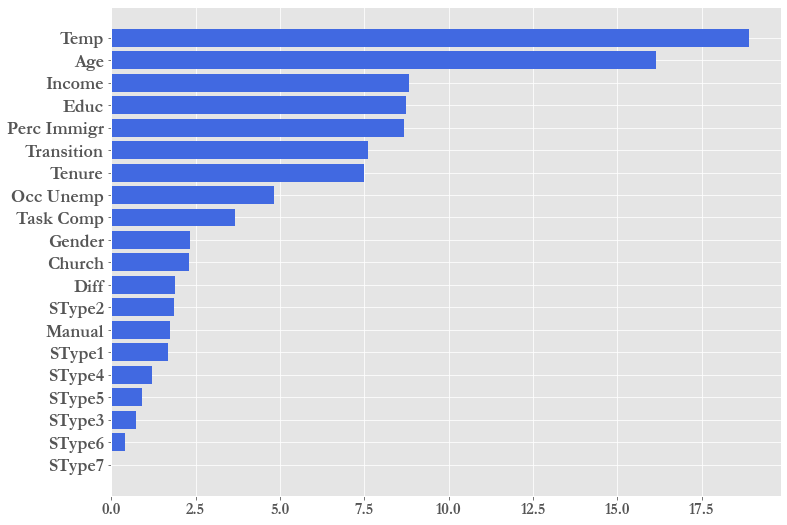

In [65]:
plt.figure(figsize=(12, 9))
bar_plot = plt.barh(importance.index, importance['importance'], color='royalblue')
plt.yticks(fontsize=18, **font_style, fontweight='bold')
plt.xticks(fontsize=16, **font_style, fontweight='bold')
# plt.savefig('rf.png', dpi=500)
plt.show()

## LASSO

In [66]:
params = {'alpha' : np.linspace(0.000001, 1, 10000)}

In [67]:
lasso_cv = GridSearchCV(estimator=Lasso(random_state=0, fit_intercept=False, max_iter=5000), 
                        param_grid=params, cv=3).fit(X_scaled, D)

In [68]:
lasso_cv.best_params_

{'alpha': 0.0024012376237623765}

In [69]:
lasso = Lasso(random_state=0, alpha=0.0024012376237623765, max_iter=5000).fit(X_scaled, D)

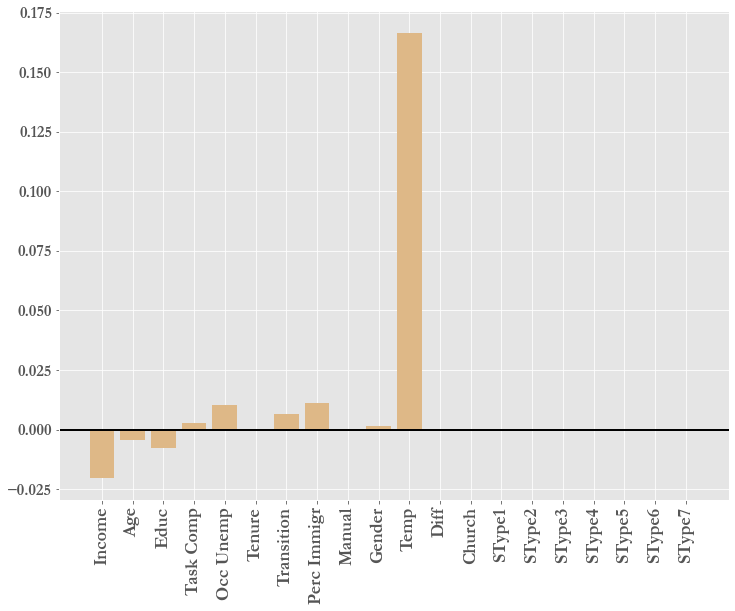

In [70]:
plt.figure(figsize=(12, 9))
plt.bar(col_names, lasso.coef_.tolist(), color='burlywood')
plt.yticks(fontsize=16, **font_style, fontweight='bold')
plt.xticks(rotation='vertical', fontsize=18, **font_style, fontweight='bold')
plt.axhline(y=0, linewidth=2, color='black')
# plt.savefig('lasso.png', dpi=500)
plt.show()

## Figures

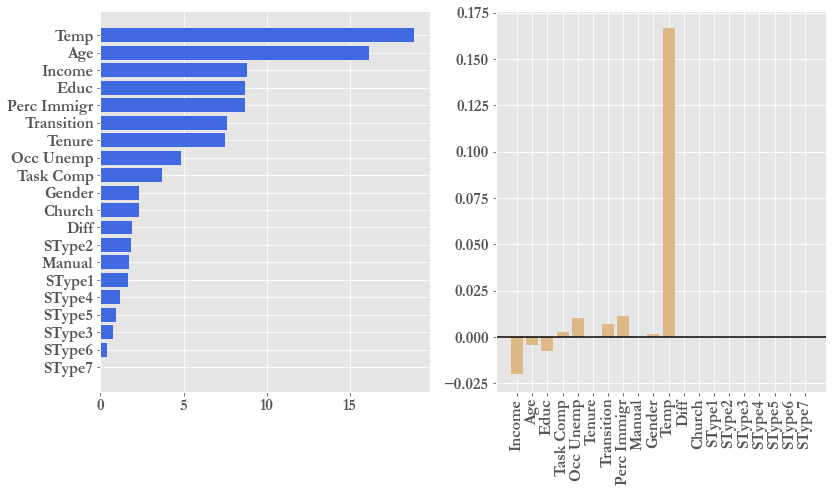

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
ax[0].tick_params(axis='both', which='major', labelsize=16, )
ax[0].barh(importance.index, importance['importance'], color='royalblue')
ax[1].tick_params(axis='x', which='major', labelrotation=90, labelsize=16)
ax[1].tick_params(axis='y', which='major', labelsize=16)
ax[1].bar(col_names, lasso.coef_.tolist(), color='burlywood')
ax[1].axhline(y=0, color='black')
plt.savefig('features.png', dpi=500, bbox_inches='tight')
plt.show()

# DMLDiD Estimation 

In [72]:
X = X[:, :-1]

In [73]:
X_scaled = X_scaled[:, :-1]

In [74]:
X_mu = X_mu[:, :-1]

In [75]:
X_mu_scaled = X_mu_scaled[:, :-1]

In [76]:
X_p = poly2.fit_transform(X)

In [77]:
X_p_scaled = min_max.fit_transform(X_p)

In [78]:
X_mu_p = poly2.fit_transform(X_mu)

In [79]:
df_p_scaled = np.concatenate((Y_1.reshape(-1, 1), Y_0.reshape(-1, 1), D.reshape(-1, 1), X_p_scaled), axis=1)

In [80]:
X_mu_p_scaled = df_p_scaled[np.where(df_p_scaled[:, 2] == 0)][:, 3:]

## Logit-L1 & LASSO

In [81]:
g_params = {'C' : [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
g_ML = LogisticRegression(random_state=0, penalty='l1', solver='saga', max_iter=10000)

In [82]:
c, alpha = 1.1, 0.05
hyp = bcch_rule(X_mu_scaled, Y_1_mu - Y_0_mu, c, alpha)

In [83]:
mu_params = {'alpha' : [hyp]}
mu_ML = Lasso(random_state=0, alpha=hyp)

In [84]:
DMLDiD(Y_1, Y_0, D, X_scaled, g_ML, g_params, mu_ML, mu_params)

(-0.0324739141913474, 0.044283887119001886)

In [85]:
c, alpha = 1.1, 0.05
hyp = bcch_rule(X_mu_p_scaled, Y_1_mu - Y_0_mu, c, alpha)

In [86]:
mu_params = {'alpha' : [hyp]}
mu_ML = Lasso(random_state=0, alpha=hyp)

In [87]:
DMLDiD(Y_1, Y_0, D, X_p_scaled, g_ML, g_params, mu_ML, mu_params)

(-0.03916775271938008, 0.04499936696711767)

## Neural Networks 

In [88]:
mspecs = [[3, 2], [2]]
optimizers = ['sgd', 'adam']
lrates = [0.00001, 0.0001, 0.001, 0.01]
regs = [0.01, 0.1, 1]

In [89]:
g_params = [mspecs, optimizers, lrates, regs]
mu_params = [mspecs, optimizers, lrates, regs]

In [90]:
DMLDiD_TF(Y_1, Y_0, D, X_scaled, X_scaled.shape[1], g_params, mu_params)

(-0.018199457451584855, 0.04445515847963718)

In [91]:
DMLDiD_TF(Y_1, Y_0, D, X_p_scaled, X_p_scaled.shape[1], g_params, mu_params)

(-0.045370940714963164, 0.04199449348802667)

## Random Forest 

In [92]:
p_max = X.shape[1]

In [93]:
g_params = {'max_depth'    : np.linspace(1, 10, 10, dtype=int),
            'max_features' : np.linspace(1, p_max, int(p_max), dtype=int)}

g_ML = RandomForestClassifier(random_state=0)

In [94]:
mu_params = {'max_depth'    : np.linspace(1, 10, 10, dtype=int),
             'max_features' : np.linspace(1, p_max, int(p_max), dtype=int)}

mu_ML = RandomForestRegressor(random_state=0)

In [95]:
DMLDiD(Y_1, Y_0, D, X, g_ML, g_params, mu_ML, mu_params)

(-0.04307322957792531, 0.04104453599710479)

In [96]:
DMLDiD(Y_1, Y_0, D, X_p, g_ML, g_params, mu_ML, mu_params)

(-0.04394188904588268, 0.0405503761561771)

## Gradient Boosting

In [97]:
g_params = {'max_depth'     : [1, 2, 3], 
            'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.5],
            'n_estimators'  : [25, 50, 75, 100, 125],
            'max_features'  : [3, 4, 5, 6, 7, 8]}

g_ML = GradientBoostingClassifier(random_state=0)

In [98]:
mu_params = {'max_depth'     : [1, 2, 3], 
             'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.5],
             'n_estimators'  : [25, 50, 75, 100, 125],
             'max_features'  : [3, 4, 5, 6, 7, 8]}

mu_ML = GradientBoostingRegressor(random_state=0)

In [99]:
DMLDiD(Y_1, Y_0, D, X, g_ML, g_params, mu_ML, mu_params)

(-0.044064483206084866, 0.04126290896869196)

In [100]:
DMLDiD(Y_1, Y_0, D, X_p, g_ML, g_params, mu_ML, mu_params)

(-0.040622249128549275, 0.041570910655469535)

## AdaBoost

In [101]:
g_params = {'learning_rate'  : [0.0001, 0.001, 0.01, 0.1, 0.5],
            'n_estimators'   : [25, 50, 75, 100, 125],
            'base_estimator' : [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), 
                                DecisionTreeClassifier(max_depth=3)]}

g_ML = AdaBoostClassifier(random_state=0)

In [102]:
mu_params = {'learning_rate'  : [0.0001, 0.001, 0.01, 0.1, 0.5],
             'n_estimators'   : [25, 50, 75, 100, 125],
             'base_estimator' : [DecisionTreeRegressor(max_depth=1), DecisionTreeRegressor(max_depth=2), 
                                 DecisionTreeRegressor(max_depth=3)]}

mu_ML = AdaBoostRegressor(random_state=0)

In [103]:
DMLDiD(Y_1, Y_0, D, X, g_ML, g_params, mu_ML, mu_params)

(-0.029582273109815014, 0.041930093252002844)

In [104]:
DMLDiD(Y_1, Y_0, D, X_p, g_ML, g_params, mu_ML, mu_params)

(-0.026613181883137292, 0.0419157445117166)

## XGBoost

In [105]:
g_params = {'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.5],
            'n_estimators'  : [25, 50, 75, 100, 125],
            'reg_lambda'    : [0.1, 0.5, 1],
            'reg_alpha'     : [0.1, 0.5, 1],
            'max_depth'     : [1, 2, 3]}

g_ML = xgb.XGBClassifier(objective='binary:logistic', random_state=0)

In [106]:
mu_params = {'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.5],
             'n_estimators'  : [25, 50, 75, 100, 125],
             'reg_lambda'    : [0.1, 0.5, 1],
             'reg_alpha'     : [0.1, 0.5, 1],
             'max_depth'     : [1, 2, 3]}

mu_ML = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)

In [107]:
DMLDiD(Y_1, Y_0, D, X, g_ML, g_params, mu_ML, mu_params)

(-0.04115000166927788, 0.04123762170090014)

In [108]:
DMLDiD(Y_1, Y_0, D, X_p, g_ML, g_params, mu_ML, mu_params)

(-0.03678867605099304, 0.041686205936385466)

In [109]:
X_p.shape[1]

209